
#  Project - Natural Language Processing                 
#   Author: María Sauras & Oscar Llorente                      
#   Date: 08/01/2023                                               

In [22]:
# machine learning and NLP libraries
import torchtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, triu
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
from gensim.matutils import corpus2dense, corpus2csc
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.models.ldamodel import LdaModel
import random

# other libraries
import warnings
from collections import Counter

# own modules
from src.utils import preprocessing, extract_data, BasicModel

# ignore warnings
warnings.filterwarnings('ignore')

# Data Extraction and Pre-Processing

In [2]:
texts, labels, costs, contributions = extract_data('data/projects.xlsx', 'data/SciVocCodes.xlsx', 0)
texts = preprocessing(texts)

# Basic Vectorization Techniques

## Tf-Idf

In [3]:
# get texts in right format
D = Dictionary([sentence.split(' ') for sentence in texts])
n_tokens = len(D)
reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]

# compute tfidf representations
tfidf = TfidfModel(reviews_bow)
reviews_tfidf = tfidf[reviews_bow]

# create sparse corpus
num_docs = len(reviews_bow)
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

In [ ]:
model = BasicModel(corpus_tfidf_sparse, labels)

In [5]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6597171278603078


In [6]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       488
           1       0.79      0.60      0.68      1326
           2       0.61      0.73      0.67       659
           3       0.38      0.41      0.40        73
           4       0.64      0.64      0.64       549
           5       0.65      0.76      0.70       111

    accuracy                           0.67      3206
   macro avg       0.61      0.66      0.63      3206
weighted avg       0.69      0.67      0.67      3206



## LDA

Since to make use of the LDA model it is necessary to define the number of topics we want in our model, we will make use of the perplexity metric.

Perplexity is a metric used to evaluate the performance of a topic model in natural language processing. It is defined as the inverse of the logarithm of the average probability of the documents in the test set under the model. 

An LDA model with a lower perplexity is considered more accurate and has a better generalization ability.


In [4]:
# Function to determine the optimal number of topics in the LDA model --> We calculate it using the perplexity metric.
def ntopics_optim(num_topics,reviews_bow,n_tokens):
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    return ldag.log_perplexity(reviews_bow)

In [5]:
def plot_perplexity(nt,perplexity):
    plt.plot(nt, perplexity, marker='o', linestyle='--', color='r', label='Perplexity') 
    plt.title("Perplexity plot to determine the number of topics")
    plt.ylabel('perplexity value')
    plt.xlabel('num of topics') 
    plt.show()

In [7]:
nt = [200, 300, 400, 500] 
perplexity = []
for i in range(len(nt)):
    p = ntopics_optim(nt[i],reviews_bow,n_tokens)
    perplexity.append(p)

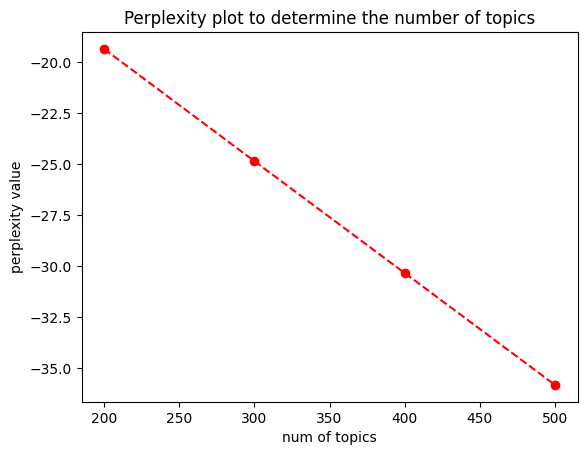

In [8]:
plot_perplexity(nt, perplexity)

Compute results with best LDA model

In [9]:
def lda_model(reviews_bow, num_topics):
    # compute LDA model
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    # create sparse corpus
    corpus_ldag = ldag[reviews_bow]
    num_docs = len(reviews_bow)
    return corpus2csc(corpus_ldag, num_terms=n_tokens, num_docs=num_docs).T

In [10]:
corpus_ldag_sparse = lda_model(reviews_bow, 500)

In [11]:
model = BasicModel(corpus_ldag_sparse, labels)

In [12]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6480271642850706


In [13]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.80      0.67       488
           1       0.78      0.54      0.64      1326
           2       0.59      0.69      0.64       659
           3       0.23      0.48      0.31        73
           4       0.60      0.57      0.59       549
           5       0.49      0.81      0.61       111

    accuracy                           0.62      3206
   macro avg       0.55      0.65      0.58      3206
weighted avg       0.66      0.62      0.63      3206



## Embeddings

First, we will compute Glove Embeddings of 300 hundred dimensions

In [16]:
embeddings = np.zeros((len(texts), 300))
glove = torchtext.vocab.GloVe(name='6B', dim=300)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [17]:
model = BasicModel(embeddings, labels)

In [18]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6768857690045743


In [19]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       488
           1       0.81      0.52      0.63      1326
           2       0.60      0.70      0.64       659
           3       0.25      0.64      0.36        73
           4       0.61      0.59      0.60       549
           5       0.49      0.79      0.60       111

    accuracy                           0.63      3206
   macro avg       0.56      0.68      0.59      3206
weighted avg       0.67      0.63      0.63      3206



Now, we could try different embeddings dimensions:

In [7]:
embeddings = np.zeros((len(texts), 50))
glove = torchtext.vocab.GloVe(name='6B', dim=50)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:06<00:00, 58432.49it/s]


In [8]:
model = BasicModel(embeddings, labels)

In [9]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6575665160497383


In [10]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.82      0.68       488
           1       0.80      0.47      0.59      1326
           2       0.56      0.65      0.60       659
           3       0.18      0.67      0.28        73
           4       0.57      0.50      0.53       549
           5       0.42      0.84      0.56       111

    accuracy                           0.58      3206
   macro avg       0.52      0.66      0.54      3206
weighted avg       0.65      0.58      0.59      3206



In [11]:
embeddings = np.zeros((len(texts), 100))
glove = torchtext.vocab.GloVe(name='6B', dim=100)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:10<00:00, 37945.69it/s]


In [12]:
model = BasicModel(embeddings, labels)

In [13]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.677253338496227


In [14]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.82      0.69       488
           1       0.81      0.50      0.62      1326
           2       0.59      0.68      0.63       659
           3       0.21      0.71      0.32        73
           4       0.60      0.53      0.56       549
           5       0.44      0.82      0.57       111

    accuracy                           0.61      3206
   macro avg       0.54      0.68      0.57      3206
weighted avg       0.67      0.61      0.61      3206



Now, we could try different embeddings

In [15]:
embeddings = np.zeros((len(texts), 300))
fast_text = torchtext.vocab.FastText(language='en')
for i in range(len(texts)):
    embeddings[i] = fast_text.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

.vector_cache/wiki.en.vec: 6.60GB [05:27, 20.1MB/s]                                                                                                                                                   
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2519370/2519370 [02:43<00:00, 15375.47it/s]


In [16]:
model = BasicModel(embeddings, labels)

In [17]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6841123405974127


In [18]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       488
           1       0.81      0.52      0.63      1326
           2       0.59      0.69      0.64       659
           3       0.23      0.64      0.34        73
           4       0.62      0.57      0.60       549
           5       0.49      0.85      0.62       111

    accuracy                           0.62      3206
   macro avg       0.56      0.68      0.59      3206
weighted avg       0.67      0.62      0.63      3206



# Basic Vectorization Techniques with Additional Features

In [14]:
costs = normalize(np.expand_dims(costs, 1), axis=1)
contributions = normalize(np.expand_dims(contributions, 1), axis=1)

## Tf-Idf

In [26]:
dataset = hstack((corpus_tfidf_sparse, csr_matrix(costs), csr_matrix(contributions)))

In [27]:
model = BasicModel(dataset, labels)

In [28]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6600972534524302


In [29]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       488
           1       0.79      0.60      0.68      1326
           2       0.61      0.73      0.67       659
           3       0.38      0.41      0.40        73
           4       0.64      0.64      0.64       549
           5       0.65      0.76      0.70       111

    accuracy                           0.67      3206
   macro avg       0.61      0.66      0.63      3206
weighted avg       0.69      0.67      0.67      3206



## LDA

In [15]:
dataset = hstack((corpus_ldag_sparse, csr_matrix(costs), csr_matrix(contributions)))

In [16]:
model = BasicModel(dataset, labels)

In [17]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6580734222587151


In [18]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       488
           1       0.78      0.50      0.61      1326
           2       0.58      0.64      0.61       659
           3       0.18      0.64      0.29        73
           4       0.59      0.53      0.56       549
           5       0.44      0.85      0.57       111

    accuracy                           0.59      3206
   macro avg       0.53      0.66      0.55      3206
weighted avg       0.65      0.59      0.60      3206



## Embeddings

In [ ]:
embeddings = np.zeros((len(texts), 300))
glove = torchtext.vocab.GloVe(name='6B', dim=300)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [37]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [42]:
model = BasicModel(dataset, labels)

In [43]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6770114603067362


In [44]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       488
           1       0.81      0.52      0.63      1326
           2       0.60      0.70      0.64       659
           3       0.25      0.64      0.36        73
           4       0.61      0.59      0.60       549
           5       0.49      0.79      0.60       111

    accuracy                           0.63      3206
   macro avg       0.56      0.68      0.59      3206
weighted avg       0.67      0.63      0.63      3206



Now we try different embeddings sizes

In [10]:
embeddings = np.zeros((len(texts), 50))
glove = torchtext.vocab.GloVe(name='6B', dim=50)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:06<00:00, 61180.77it/s]


In [15]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [16]:
model = BasicModel(dataset, labels)

In [17]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.659179933268497


In [18]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.81      0.68       488
           1       0.79      0.47      0.59      1326
           2       0.56      0.64      0.60       659
           3       0.17      0.67      0.28        73
           4       0.57      0.50      0.54       549
           5       0.44      0.86      0.58       111

    accuracy                           0.58      3206
   macro avg       0.52      0.66      0.54      3206
weighted avg       0.65      0.58      0.59      3206



In [19]:
embeddings = np.zeros((len(texts), 100))
glove = torchtext.vocab.GloVe(name='6B', dim=100)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:10<00:00, 39145.82it/s]


In [20]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [21]:
model = BasicModel(dataset, labels)

In [22]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6788271121206221


In [23]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       488
           1       0.80      0.50      0.61      1326
           2       0.58      0.67      0.62       659
           3       0.21      0.73      0.32        73
           4       0.60      0.52      0.56       549
           5       0.44      0.83      0.57       111

    accuracy                           0.60      3206
   macro avg       0.54      0.68      0.56      3206
weighted avg       0.66      0.60      0.61      3206



In [24]:
embeddings = np.zeros((len(texts), 50))
glove = torchtext.vocab.GloVe(name='6B', dim=50)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [25]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [26]:
model = BasicModel(dataset, labels)

In [27]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.659179933268497


In [28]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.58      0.81      0.68       488
           1       0.79      0.47      0.59      1326
           2       0.56      0.64      0.60       659
           3       0.17      0.67      0.28        73
           4       0.57      0.50      0.54       549
           5       0.44      0.86      0.58       111

    accuracy                           0.58      3206
   macro avg       0.52      0.66      0.54      3206
weighted avg       0.65      0.58      0.59      3206



As before, we also explore another type of embeddings

In [29]:
embeddings = np.zeros((len(texts), 300))
fast_text = torchtext.vocab.FastText(language='en')
for i in range(len(texts)):
    embeddings[i] = fast_text.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2519370/2519370 [02:54<00:00, 14472.03it/s]


In [30]:
dataset = np.concatenate((embeddings, costs, contributions), axis=1)

In [31]:
model = BasicModel(dataset, labels)

In [32]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.6829134109807464


In [33]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       488
           1       0.81      0.51      0.62      1326
           2       0.59      0.67      0.63       659
           3       0.21      0.67      0.33        73
           4       0.61      0.56      0.58       549
           5       0.49      0.86      0.62       111

    accuracy                           0.62      3206
   macro avg       0.55      0.68      0.58      3206
weighted avg       0.67      0.62      0.62      3206



# Graph Analysis

In [19]:
def embedding(texts,num_topics):
    # Create a corpus
    D = Dictionary([s.split(' ') for s in texts])
    n_tokens = len(D)
    reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]
    # compute using a LDA algorithm for topic modelling
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    return ldag, reviews_bow

In [20]:
ldag, reviews_bow = embedding(texts,500) # Numer of topics = 500

###  Corpus processing and analysis 

In [21]:
corpus_size = len(reviews_bow)
print(f"Dataset contains {corpus_size} documents")

Dataset contains 32052 documents


**Note:** We note that it has 32,052 documents. Since this is a very high number, we will limit the number of documents to be analyzed to about 1000 documents.

In [23]:
num_docs = 1000
random.seed(10)
corpus = random.sample(reviews_bow, num_docs)
print(f"Dataset contains {len(corpus)} documents")

Dataset contains 1000 documents


In [24]:
corpus_ldag = ldag[corpus]
X = corpus2csc(corpus_ldag).T

In [25]:
n_topics = X.shape[1]
print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {X.nnz} nonzero values out of {num_docs * n_topics}")

Number of topics: 500
X: sparse matrix with 21490 nonzero values out of 500000


In [26]:
# Note that the embedding is shown in sparse format, showing the non-zero values only. The proportion of zero entries is
print(f"{(1 - X.nnz / num_docs / n_topics) * 100:.2f} % ")

95.70 % 


In [27]:
# All other entries are values in  [0,1] . 

average_row = np.mean(X.sum(axis=1).T)
print(f"Average row sum: {average_row:.2f}")
if average_row != 1.0: # If the row of vectros are not sum to one, we need to normalize this.
    X = scsp.csr_matrix(X / np.sum(X, axis=1))
average_row = np.mean(X.sum(axis=1).T)
print(f"Average row sum after normalization: {average_row:.2f}")

Average row sum: 0.88
Average row sum after normalization: 1.00


### Semantic Similarity Measures

In order to construct a semantic graph from a collection of document embeddings, a similary measure between two embeddings,  𝐱  and  𝐲 , is required.

To do this, we define differents steps:

1. Determine the most and the least similar documents in the dataframe, according to the BC similarity measure.
2. Compute the indices of the least similar and the most similar documents in the dataframe (excluding the document itself).
3. Compute a similarity matrix  𝐒 for a similarity graph.

##### 1. Similarity between documents

In [28]:
# Función que nos devuelve la similitud de los documentos con el documento i
def similarity_docs(i,X): 
    xi = X[i, :]
    return np.multiply(np.sqrt(xi),np.sqrt(X[1:].T)) # Excluimos el elemento i

In [29]:
# Similitud con el documento 0
print(similarity_docs(0,X))

  (0, 996)	0.11435015680524187
  (0, 951)	0.06892359747497998
  (0, 950)	0.2524782213814956
  (0, 926)	0.07407590351911046
  (0, 886)	0.13989557887734075
  (0, 869)	0.20452559506501158
  (0, 857)	0.13863895222346467
  (0, 849)	0.11322515608900784
  (0, 812)	0.1080933839688015
  (0, 762)	0.108652762970106
  (0, 721)	0.09864718876596722
  (0, 710)	0.23066724437383287
  (0, 704)	0.06845328234932693
  (0, 654)	0.13588151343902632
  (0, 631)	0.08152926238236524
  (0, 627)	0.08730008070991392
  (0, 497)	0.16059426136306929
  (0, 467)	0.06696827345734313
  (0, 450)	0.11033230332332437
  (0, 449)	0.131207879275272
  (0, 398)	0.057404189855482055
  (0, 381)	0.1448560748958127
  (0, 369)	0.06551665112131938
  (0, 277)	0.09117191153216474
  (0, 270)	0.25133474383517695
  :	:
  (0, 542)	0.032876459845055744
  (0, 530)	0.01760812513390245
  (0, 505)	0.18762574731297715
  (0, 441)	0.3654570137198044
  (0, 411)	0.030879353508261334
  (0, 336)	0.2519413725092943
  (0, 323)	0.24189629237210591
  (0, 30

In [30]:
BC = similarity_docs(0,X)
arg_max = np.argmax(BC)
print('Most similar: ',arg_max)
arg_min = np.argmin(BC)
print('Least similar: ',arg_min)

Most similar:  184
Least similar:  4


##### 2. Compute the similarity matrix S based on the BC.

In [31]:
S = np.multiply(np.sqrt(X),np.sqrt(X.T))

print('Number of nonzero:',S.nnz)
print(f"NON-ZERO proportion = {(S.nnz/(S.shape[0]*S.shape[1]))*100:0.2f} %")

Number of nonzero: 729388
NON-ZERO proportion = 72.94 %


Note that the matrix is symmetric so we keep only with upper triangular part

In [32]:
S = triu(S,k = 1) # above diagonal
print('Number of non-zero components in S:', S.nnz )

Number of non-zero components in S: 364194


### Semantic Graph

For the representation of the graphs, we have chosen to follow the following steps:

1. Graph construction
2. Visualize Graphs with layout algorithms
3. Visualize Graphs with Community detection algorithms
4. Impact

##### 1. Graph Construction

In [33]:
n_nodes = num_docs                                  # the documents in the corpus
n_edges = S.nnz                                     # links connecting pairs of documents with nonzero similarity 
n_edges_per_node = np.round(n_edges/n_nodes)        # the similarity values 

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")

Number of nodes: 1000
Number of edges: 364194
Number of edges per node: 364.0


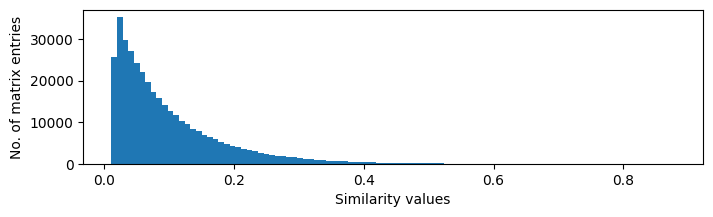

In [34]:
plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

1.1 Apply a threshold to sparse matrix in order to get a subgraph with an average of 10 edges per node.

In [35]:
# Set average number of edges per node
n_edges_per_node = 10
sample_factor = num_docs / corpus_size

# Compute threshold to get the target number of edges

n_edges = n_nodes * n_edges_per_node
sort = np.sort(S.data)
inv_sort = sort[::-1]
thr = inv_sort[n_edges]

# Apply the threshold to similarity matrix
S.data[S.data<thr] = 0
S.eliminate_zeros()

n_links = len(S.data)/2/sample_factor**2

print(f"Threshold: {thr:.4f}")
print(f"Number of edges: {n_edges}")
print(f"Estimated number of links in full corpus: {n_links:.2f}")

Threshold: 0.3093
Number of edges: 10000
Estimated number of links in full corpus: 5137167.19


##### 2. Layout Algorithms

In [36]:
G = nx.from_scipy_sparse_matrix(S)

2.1 Testing Random Layout

*This algorithm is used to visualize graphs and data networks randomly. This algorithm places the nodes of the graph randomly in the visualization space and then connects the nodes with lines representing the relationships between them.*

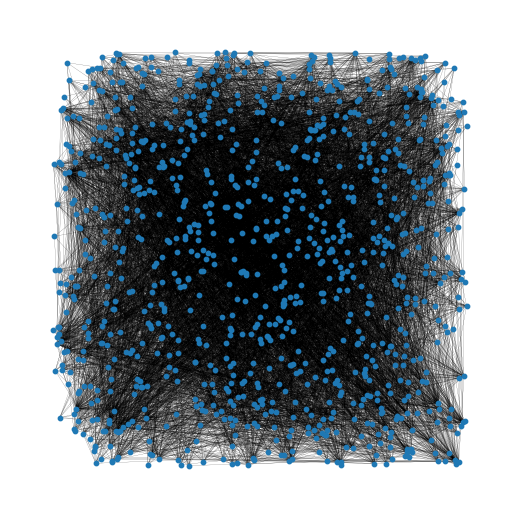

In [37]:
# ##########################
# Testing a random  layout #
# ##########################

positions = nx.drawing.layout.random_layout(G)
plt.figure(figsize=(5,5))
nx.draw(G, positions, node_size=10, width=0.10)

2.2 Testing a Fruchterman-Reingold: Forced-directed algorithm

*Such an algorithm is used to arrange the nodes so that the relationships between them are easy to see. This algorithm is an example of a force-directed algorithm, which means that it uses a series of forces to move and arrange the nodes in the display space.* 

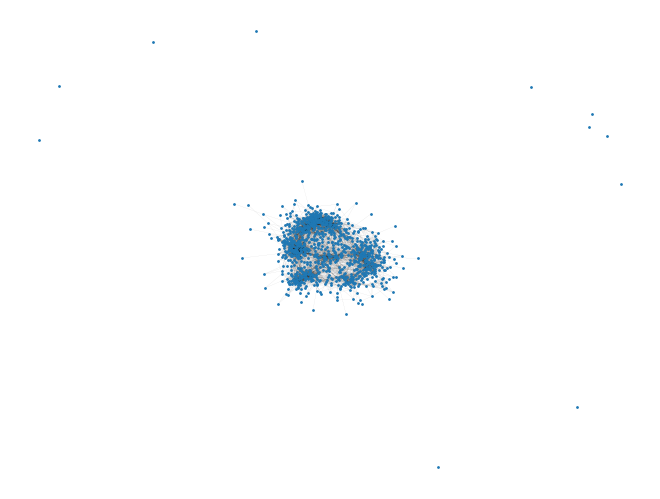

In [38]:
########################################################################
#       Testing a Fruchterman-Reingold: Forced-directed algorithm      #
########################################################################
# Compute positions
positions = nx.spring_layout(G, iterations = 50, seed = 0)

# Draw graph
nx.draw(G, positions, node_size=1, width=0.02)

2.3 Largest connected component (LCC)

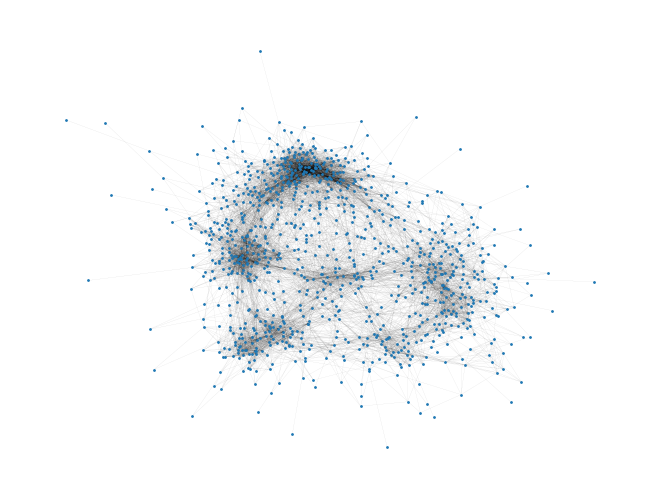

In [39]:
########################################################################
#           Largest connected component (LCC) from the graph           #
########################################################################

largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc) # saving LCC in a subgraph
nx.draw(G_lcc, positions, node_size=1, width=0.02)

##### 3. Community detection

3.1 Define community algorith to detect communities

In [65]:
import networkx.algorithms.community as nx_comm

# Detecting communities in a graph using the greedy modularity algorithm. 
# This function takes a graph and a resolution parameter as arguments and returns a list of communities detected in the graph.
# The resolution parameter of the community.greedy_modularity_communities() function controls 
# the amount of clustering that is performed on the network. 
# To determine the optim value of resolution we use differents numbers to study the modularity.
# (MCM)
for resolution in [0.5, 1, 1.5, 2, 2.5 ,3, 3.5]:
    C = nx_comm.greedy_modularity_communities(G_lcc, resolution=resolution)
    # Modularity of the partition
    modularity = nx_comm.modularity(G_lcc, C)
    nc = len(C)
    print(f"Number of communities: {nc}")
    print(f"Modularity: {modularity:.2f}")
    print(f"Resolution: {resolution}")
    print("\n---------------------------")

Number of communities: 3
Modularity: 0.42
Resolution: 0.5

---------------------------
Number of communities: 5
Modularity: 0.59
Resolution: 1

---------------------------
Number of communities: 9
Modularity: 0.62
Resolution: 1.5

---------------------------
Number of communities: 13
Modularity: 0.64
Resolution: 2

---------------------------
Number of communities: 21
Modularity: 0.63
Resolution: 2.5

---------------------------
Number of communities: 20
Modularity: 0.60
Resolution: 3

---------------------------
Number of communities: 19
Modularity: 0.61
Resolution: 3.5

---------------------------


The best value for the resolution is 2 since the modularity value is the highest. This means that the quality of the partition is higher than the others.

In [41]:
C = nx_comm.greedy_modularity_communities(G_lcc, resolution=2)

3.2 Check that the size of the communities.

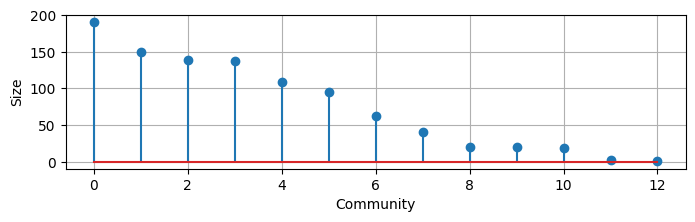

In [42]:
# Sort communities by decreasing size
C = sorted(C, key=len, reverse=True)
# Number of communities
nc = len(C)

# Size of each community
comm_sizes = [len(x) for x in C]

plt.figure(figsize=(8, 2))
plt.stem(range(nc), comm_sizes)
plt.xlabel('Community')
plt.ylabel('Size')
plt.grid('on')
plt.show()

3.3 Draw graph with color palette to show the differents communities

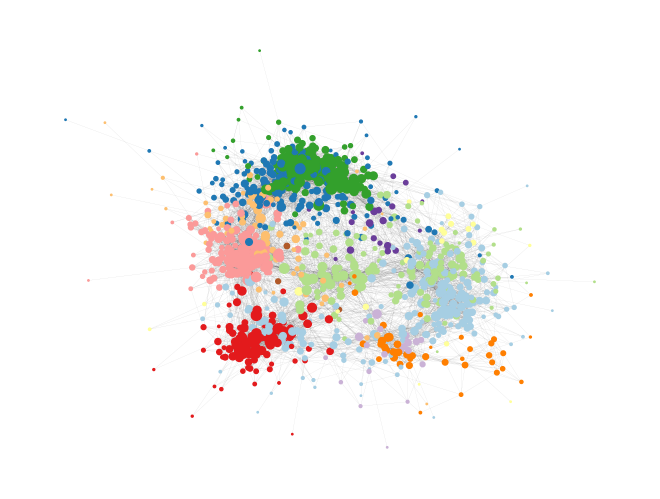

In [43]:
palette = sns.color_palette(palette="Paired", n_colors=nc)
node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

# Map node attribute to rgb colors
node_colors = [palette[node2comm[node]] for node in G_lcc]

# Get list of degrees
degrees = [degree[1] for degree in G_lcc.degree]

#  Draw graph
nx.draw(G_lcc, positions, node_size=degrees, width=0.02, 
        node_color=node_colors)

3.4 Quality Metrics

In [44]:
coverage, performance = nx_comm.partition_quality(G_lcc, C)

print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Coverage: 0.7758224177582241
Performance: 0.8843042700474449


*Results obtained:*

**COVERAGE**:  is a metric used to evaluate the ability of a natural language model to process a dataset. It is defined as the proportion of words in the dataset that are recognized by the model. A higher coverage value indicates a greater ability of the model to process the dataset.

**PERFORMANCE**: is a metric used to evaluate the accuracy of a natural language model. It can be measured in different ways, depending on the type of task being performed

Since both the performance and coverage values are high, the results obtained are good.
As a noteworthy aspect of the values obtained is that the coverage is lower than the performance. This means that the natural language model is able to process a smaller amount of words in the dataset, but it is more accurate in performing the assigned task.

3.5 Community networks

In [45]:
# Convert matrix to csr
S2 = scsp.csr_matrix(S + S.T)

# Initialize matrix for the community graph
M = np.zeros((nc, nc))

# Loop over the communities
for i in range(nc):
    nodes_i = list(C[i])
    ni = len(nodes_i)
    
    # Loop over the communities
    for j in range(i+1, nc):
        nodes_j = list(C[j])
        n_j = len(nodes_j)

        # Select submatrix Sij, with rows from Ci and columns from Cj
        Sij = S2[nodes_i][:, nodes_j] 
        
        # Compute M
        M[i, j] = (1/(ni*n_j))*np.sum(np.sum(Sij))

In [46]:
CG = nx.from_numpy_matrix(M)
positions_CG = nx.spring_layout(CG, iterations = 50, seed = 0)

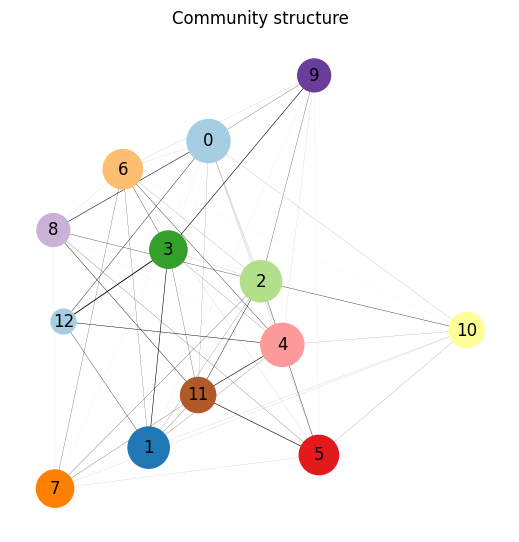

In [47]:
# Compute edge widths  & node sizes
w = [e[2]['weight']*50 for e in CG.edges(data=True)]
degrees = [val * 80 for (node, val) in CG.degree()]

plt.figure(figsize=(5,5))
nx.draw(CG, positions_CG, node_size=degrees, width=w, node_color=palette, with_labels=True)
plt.title("Community structure")
plt.show()

##### 4. Impact

In this section we will explore measures to evaluate the role of a node in its network, using a family of centrality measures, that evaluate nodes according to their position in the graph.

In [72]:
df = pd.DataFrame(texts, columns=['reviews'])
df.head(1)

,reviews
0,ebola virus modern approach developing bedside...


In [79]:
# Function to  print top 3 nodes from the graphs
def print_top3_nodes(impact):
    sorted_ctr = sorted(impact, key=lambda x: x[1], reverse=True)
    ctr3 = sorted_ctr[2][1]
    print(ctr3)

    eps = 1e-5
    node_sizes = [20 * x[1] / ctr3 * (x[1] > ctr3 - eps) for x in impact]

    # Plot graph
    plt.figure(figsize=(4, 4))
    nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)
    # Print top 3 nodes
    top3_nodes = [x[0] for x in sorted_ctr[:3]]
    df_best = df.iloc[top3_nodes][['reviews']]
    print(df_best)

4.1 Degree centrality.

In [77]:
# Compute centrality
centrality = [(k, v) for k, v in nx.degree_centrality(G_lcc).items()]

# Print the sum of all centrality values:
sum_gw = np.sum(list(nx.degree_centrality(G_lcc).values()))
print(f"Sum of all graph weights: {sum_gw:.2f}")

Sum of all graph weights: 20.24


Print the top 3 nodes with the highest centrality:

0.08603238866396762
                                               reviews
915  implementation preliminary validation novel no...
538  genome wide analysis rna protein interacting p...
876  natural sense vision acoustic hapticssound vis...


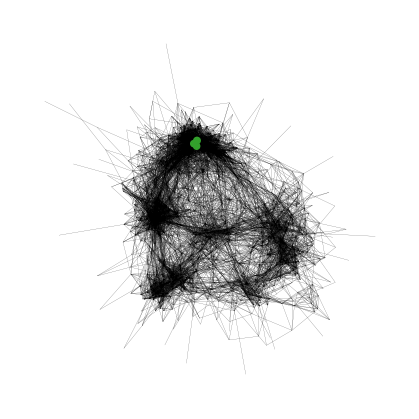

In [80]:
print_top3_nodes(centrality)

4.2 Closeness

In [81]:
dict_edges = nx.get_edge_attributes(G_lcc, 'weight')

edges = {}
for k, v in dict_edges.items(): edges[k] = v

nx.set_edge_attributes(G_lcc, edges, 'distance')

# Compute centrality
centrality = nx.closeness_centrality(G_lcc, distance = 'distance')

1.0887224421012576
                                               reviews
266  cbrne detection containersthe threat cbrne che...
126  quantum plasmomechanics thz phonons molecular ...
926  mathematical frontier analysis many particle s...


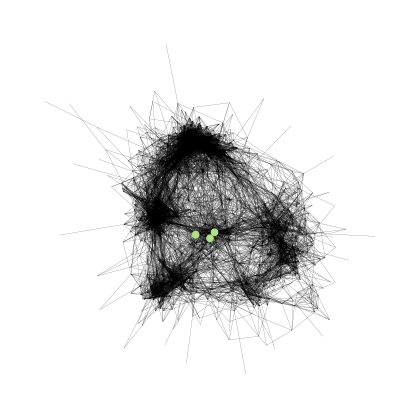

In [82]:
print_top3_nodes(centrality.items())

4.3 Betweenness

0.023181855781321793
                                               reviews
17   impact superfluidity superconductivity magneto...
266  cbrne detection containersthe threat cbrne che...
898  continuation effort local enterprise europe ne...


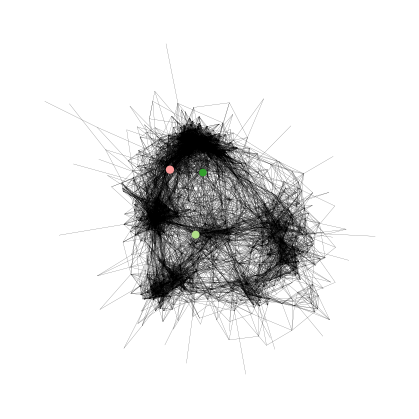

In [83]:
# Compute centrality
centrality = nx.betweenness_centrality(G_lcc)
print_top3_nodes(centrality.items())

4.4 PageRank

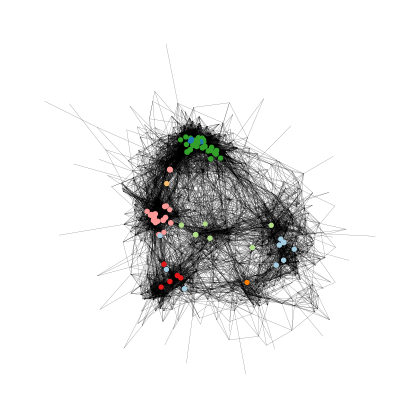

In [84]:
centrality = nx.pagerank(G_lcc)
node_sizes = [4000 * x * (x > 0.00185) for x in centrality.values()]
plt.figure(figsize=(4,4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

# Classification Second Level

In [55]:
texts, labels, costs, contributions = extract_data('data/projects.xlsx', 'data/SciVocCodes.xlsx', 1)
texts = preprocessing(texts)

## Tf-Idf

In [56]:
# get texts in right format
D = Dictionary([sentence.split(' ') for sentence in texts])
n_tokens = len(D)
reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]

# compute tfidf representations
tfidf = TfidfModel(reviews_bow)
reviews_tfidf = tfidf[reviews_bow]

# create sparse corpus
num_docs = len(reviews_bow)
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

In [4]:
model = BasicModel(corpus_tfidf_sparse, labels, 0.3)

In [5]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.37647629711564673


In [6]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.28      0.39      0.33       188
           1       0.54      0.53      0.54       582
          10       0.48      0.45      0.46       497
          11       0.15      0.14      0.15        35
          12       0.40      0.40      0.40        68
          13       0.30      0.17      0.21        36
          14       0.38      0.43      0.40       282
          15       0.27      0.08      0.12        53
          16       0.52      0.59      0.55       636
          17       0.40      0.42      0.41        80
          18       0.00      0.00      0.00        12
          19       0.52      0.49      0.51       554
           2       0.45      0.58      0.51       201
          20       0.34      0.51      0.40       176
          21       0.32      0.36      0.34        91
          22       0.00      0.00      0.00        13
          23       0.31      0.52      0.39       139
          24       0.29    

## LDA

In [57]:
corpus_ldag_sparse = lda_model(reviews_bow, 500)

In [58]:
model = BasicModel(corpus_ldag_sparse, labels)

In [59]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.2784750125697859


In [60]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.27      0.22      0.24        64
           1       0.44      0.48      0.46       203
          10       0.42      0.43      0.43       172
          11       0.00      0.00      0.00        13
          12       0.36      0.16      0.22        25
          13       0.25      0.12      0.17         8
          14       0.25      0.31      0.28        87
          15       0.00      0.00      0.00        18
          16       0.45      0.52      0.48       196
          17       0.33      0.14      0.20        29
          18       0.00      0.00      0.00         4
          19       0.36      0.40      0.38       180
           2       0.43      0.57      0.49        69
          20       0.25      0.29      0.27        51
          21       0.18      0.12      0.15        32
          22       0.50      0.20      0.29         5
          23       0.17      0.18      0.18        39
          24       0.17    

## Embeddings

In [4]:
embeddings = np.zeros((len(texts), 300))
glove = torchtext.vocab.GloVe(name='6B', dim=300)
for i in range(len(texts)):
    embeddings[i] = glove.get_vecs_by_tokens(texts[i].split(' '), lower_case_backup=True).mean(dim=0).numpy()

In [5]:
model = BasicModel(embeddings, labels, 0.3)

In [6]:
print(f'accuracy: {model.accuracy}')

accuracy: 0.36807103364739163


In [7]:
print(model.classification_report)

              precision    recall  f1-score   support

           0       0.20      0.35      0.25       188
           1       0.50      0.49      0.50       582
          10       0.48      0.41      0.44       497
          11       0.11      0.29      0.16        35
          12       0.21      0.46      0.29        68
          13       0.14      0.22      0.17        36
          14       0.32      0.39      0.35       282
          15       0.12      0.17      0.14        53
          16       0.53      0.50      0.52       636
          17       0.22      0.46      0.29        80
          18       0.17      0.08      0.11        12
          19       0.48      0.40      0.44       554
           2       0.38      0.64      0.48       201
          20       0.26      0.48      0.34       176
          21       0.19      0.42      0.26        91
          22       0.00      0.00      0.00        13
          23       0.24      0.35      0.28       139
          24       0.19    